In [38]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()
import chart_studio.plotly as py
import cufflinks as cf
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
cf.go_offline()

import matplotlib.font_manager as fm
path = 'C:\Windows\Fonts\malgunbd.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)

In [39]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [40]:
def Feature_extracy(data):
    feature_columns = list(data.columns.difference(["평가점수"]))
    y = data.평가점수
    data = data[feature_columns]
    data = data.drop(['이용가능연령구분','카테고리','장르','버전','안드로이드버전'],axis = 1)
    data['app이름길이'] = data.app이름.apply(lambda x : len(x))
    return data, y

In [41]:
def Applen(data):
    data['app이름길이'] = data.app이름.apply(lambda x : len(x))
    data = data.drop(['app이름'],axis = 1)
    return data

In [42]:
def Appsize(data):
    data.app크기[data.app크기 == "Varies with device"] = "1M"
    Size = data.app크기.unique()
    
    app_size = []
    # M이 있을 경우에 제외하고 x1024, k있을 경우는 그냥 k만 지우자
    for i in Size:
        if i[-1] == "M":
            temp_data = float(i.replace("M",""))
            temp_data *= 1024
            app_size.append(temp_data)
        else:
            temp_data_2 = float(i.replace("k",""))
            app_size.append(temp_data_2)
            
    dict_app = {}
    for i in range(len(Size)):
        dict_app[Size[i]] = app_size[i]
    
    data['app크기'] = data.app크기.apply(lambda x : dict_app[x])
    
    return data

In [43]:
def Price_adh(data):
    data.가격 = data.가격.apply(lambda x : x.replace("$",""))
    data.가격 = data.가격.apply(lambda x : x.replace(",",""))
    data.가격 = data.가격.apply(lambda x : float(x.replace(",","")))
    return data

In [44]:
def Down_adj(data):
    data.다운로드수 = data.다운로드수.apply(lambda x : x.replace("+",""))
    data.다운로드수 = data.다운로드수.apply(lambda x : x.replace(",",""))
    data.다운로드수 = data.다운로드수.apply(lambda x : x.replace(",",""))
    data.다운로드수 = data.다운로드수.apply(lambda x : int(x))
    return data

버전 다듬는 용

In [45]:
def Version_adj(data):
    Month_dict = {"January" : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May' : 5,'June':6,'July' : 7,'August' : 8,'September' : 9,'October' : 10, "November" : 11, "December" : 12  }
    Month = data.마지막업데이트.str.split(' ').str[0]
    Month_data = Month.apply(lambda x : Month_dict[x])
    
    BBB = data.마지막업데이트.str.split(' ').str[1:]
    Day = BBB.str[0].apply(lambda x : int(x.replace(',','')))
    Year = BBB.str[1].apply(lambda x : int(x))
    return Month_data, Day, Year

In [46]:
def Update_version(data,Month,Day,Year):
    data = data.drop(['마지막업데이트'],axis = 1)
    data['업데이트_월'] = Month
    data['업데이트_일'] = Day
    data['업데이트_연도'] = Year
    return data

In [47]:
def All_adj(data):
    data = Applen(data)
    data = Appsize(data)
    Month,Day,Year = Version_adj(data)
    data = Update_version(data,Month,Day,Year)
    return data

In [48]:
def Distplot(data):
    plt.figure(figsize = (20,30))
    plt.subplot(3,1,1)
    sns.regplot(data.업데이트_월,y)
    
    plt.subplot(3,1,2)
    sns.regplot(data.업데이트_일,y)
    
    plt.subplot(3,1,3)
    sns.regplot(data.업데이트_연도,y)

In [49]:
def Cramer(data):
    from scipy.stats import chi2_contingency
    import numpy as np

    def cramers_V(var1,var2):
        crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
        stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
        obs = np.sum(crosstab) # Number of observations
        mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
        return (stat/(obs*mini))
    from sklearn import preprocessing

    label = preprocessing.LabelEncoder()
    data_encoded = pd.DataFrame() 

    for i in data.columns:
        data_encoded[i]=label.fit_transform(data[i])

    rows= []

    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
    return df

In [50]:
def Change(data):
    data.리뷰수 = data.리뷰수.apply(lambda x: int(x))
    data['리_다'] = data.리뷰수 / data.다운로드수
    data= data.drop(['리뷰수','다운로드수'],axis = 1)
    return data

In [51]:
def Graph(data):
    plt.figure(figsize = (10,40))
    plt.subplot(5,1,1)
    sns.regplot(data.app크기,y,scatter_kws = {'color' : 'black','s':10},line_kws={'color':'red'})
    plt.subplot(5,1,2)
    sns.regplot(data.리_다,y,scatter_kws = {'color' : 'black','s':10},line_kws={'color':'red'})
    plt.subplot(5,1,3)
    sns.regplot(data.app이름길이,y,scatter_kws = {'color' : 'black','s':10},line_kws={'color':'red'})
    plt.subplot(5,1,4)
    sns.regplot(data.가격,y,scatter_kws = {'color' : 'black','s':10},line_kws={'color':'red'})
    plt.subplot(5,1,5)
    sns.regplot(data.업데이트_연도,y,scatter_kws = {'color' : 'black','s':10},line_kws={'color':'red'})

In [52]:
with open("Mature_17.pickle",'rb') as f:
    Mature_17 = pickle.load(f)

In [53]:
def Check_appname(data,name):
    Temp_data = data[data.장르 == name]
    Temp2 = Temp_data[['app이름','다운로드수']]
    return Temp2.sort_values(by = "다운로드수",ascending = False)

In [54]:
Check_appname(Mature_17,"Dating")[:50]

,app이름,다운로드수
6286,"Moco - Chat, Meet People",10000000
489,"Moco - Chat, Meet People",10000000
574,"Chat Rooms, Avatars, Date - Galaxy",10000000
591,Hitwe - meet people and chat,10000000
532,"Chat Rooms, Avatars, Date - Galaxy",10000000
542,OkCupid Dating,10000000
491,Hot or Not - Find someone right now,10000000
502,Find Real Love — YouLove Premium Dating,10000000
551,"Moco - Chat, Meet People",10000000
6302,OkCupid Dating,10000000


In [55]:
Check_appname(Mature_17,"Entertainment")[:50]

,app이름,다운로드수
8443,Meme Generator Free,10000000
914,STARZ,10000000
934,STARZ,10000000
956,FOX,10000000
964,STARZ,10000000
984,FOX,10000000
5049,iFunny :),10000000
5425,Virtual Cigarette Smoking (prank),5000000
7451,FANDOM for: GTA,5000000
5178,Replika,1000000


In [56]:
Check_appname(Mature_17,"Action")[:50]

,app이름,다운로드수
4051,Sniper 3D Gun Shooter: Free Shooting Games - FPS,100000000
1723,Sniper 3D Gun Shooter: Free Shooting Games - FPS,100000000
1756,Sniper 3D Gun Shooter: Free Shooting Games - FPS,100000000
1910,Sniper 3D Gun Shooter: Free Shooting Games - FPS,100000000
1925,Sniper 3D Gun Shooter: Free Shooting Games - FPS,100000000
1699,Sniper 3D Gun Shooter: Free Shooting Games - FPS,100000000
9166,Modern Combat 5: eSports FPS,100000000
4146,Gangstar Vegas - mafia game,50000000
1936,DEAD TARGET: FPS Zombie Apocalypse Survival Games,50000000
2009,DEAD TARGET: FPS Zombie Apocalypse Survival Games,50000000


In [57]:
Check_appname(Mature_17,"Social")[10:70]

,app이름,다운로드수
2593,MeetMe: Chat & Meet New People,50000000
2617,MeetMe: Chat & Meet New People,50000000
2642,POF Free Dating App,50000000
2646,"SKOUT - Meet, Chat, Go Live",50000000
2630,MeetMe: Chat & Meet New People,50000000
2629,POF Free Dating App,50000000
4232,POF Free Dating App,50000000
2614,"SKOUT - Meet, Chat, Go Live",50000000
6293,MeetMe: Chat & Meet New People,50000000
2643,MeetMe: Chat & Meet New People,50000000


In [58]:
Check_appname(Mature_17,"Communication")[:50]

,app이름,다운로드수
370,Telegram,100000000
392,Telegram,100000000
4592,Telegram,100000000
3892,Azar,50000000
362,TouchPal Keyboard - Fun Emoji & Android Keyboard,10000000
435,Hiya - Caller ID & Block,10000000
437,Mr. Number-Block calls & spam,10000000
7124,Channel 19,100000
4636,/u/app,10000


In [59]:
Check_appname(Mature_17,"News & Magazines")[:50]

,app이름,다운로드수
3739,Twitter,500000000
3796,Twitter,500000000
4115,Twitter,500000000
3734,"Reddit: Social News, Trending Memes & Funny Vi...",10000000
3738,"Topbuzz: Breaking News, Videos & Funny GIFs",10000000
4588,"Topbuzz: Breaking News, Videos & Funny GIFs",10000000
9631,"NewsDog - Latest News, Breaking News, Local News",10000000
3746,"Onet - news, weather, sport",1000000
3773,World Newspapers,1000000
3817,BaconReader for Reddit,1000000


In [60]:
Mature_17.장르.value_counts()

Dating                     179
Social                      66
Action                      52
Entertainment               37
News & Magazines            13
Simulation                  10
Lifestyle                    9
Communication                9
Comics                       9
Sports                       8
Personalization              8
Health & Fitness             7
Medical                      6
Adventure                    6
Education                    5
Photography                  5
Racing                       5
Strategy                     4
Shopping                     3
Role Playing                 3
Books & Reference            3
Arcade                       2
Word                         2
Video Players & Editors      2
Music                        2
Weather                      1
Travel & Local               1
Maps & Navigation            1
Card                         1
Productivity                 1
Casual                       1
Tools                        1
Beauty  

In [61]:
Mature_17, y = Feature_extracy(Mature_17)

In [62]:
Mature_17 = All_adj(Mature_17)

In [63]:
Mature_17 = Change(Mature_17)

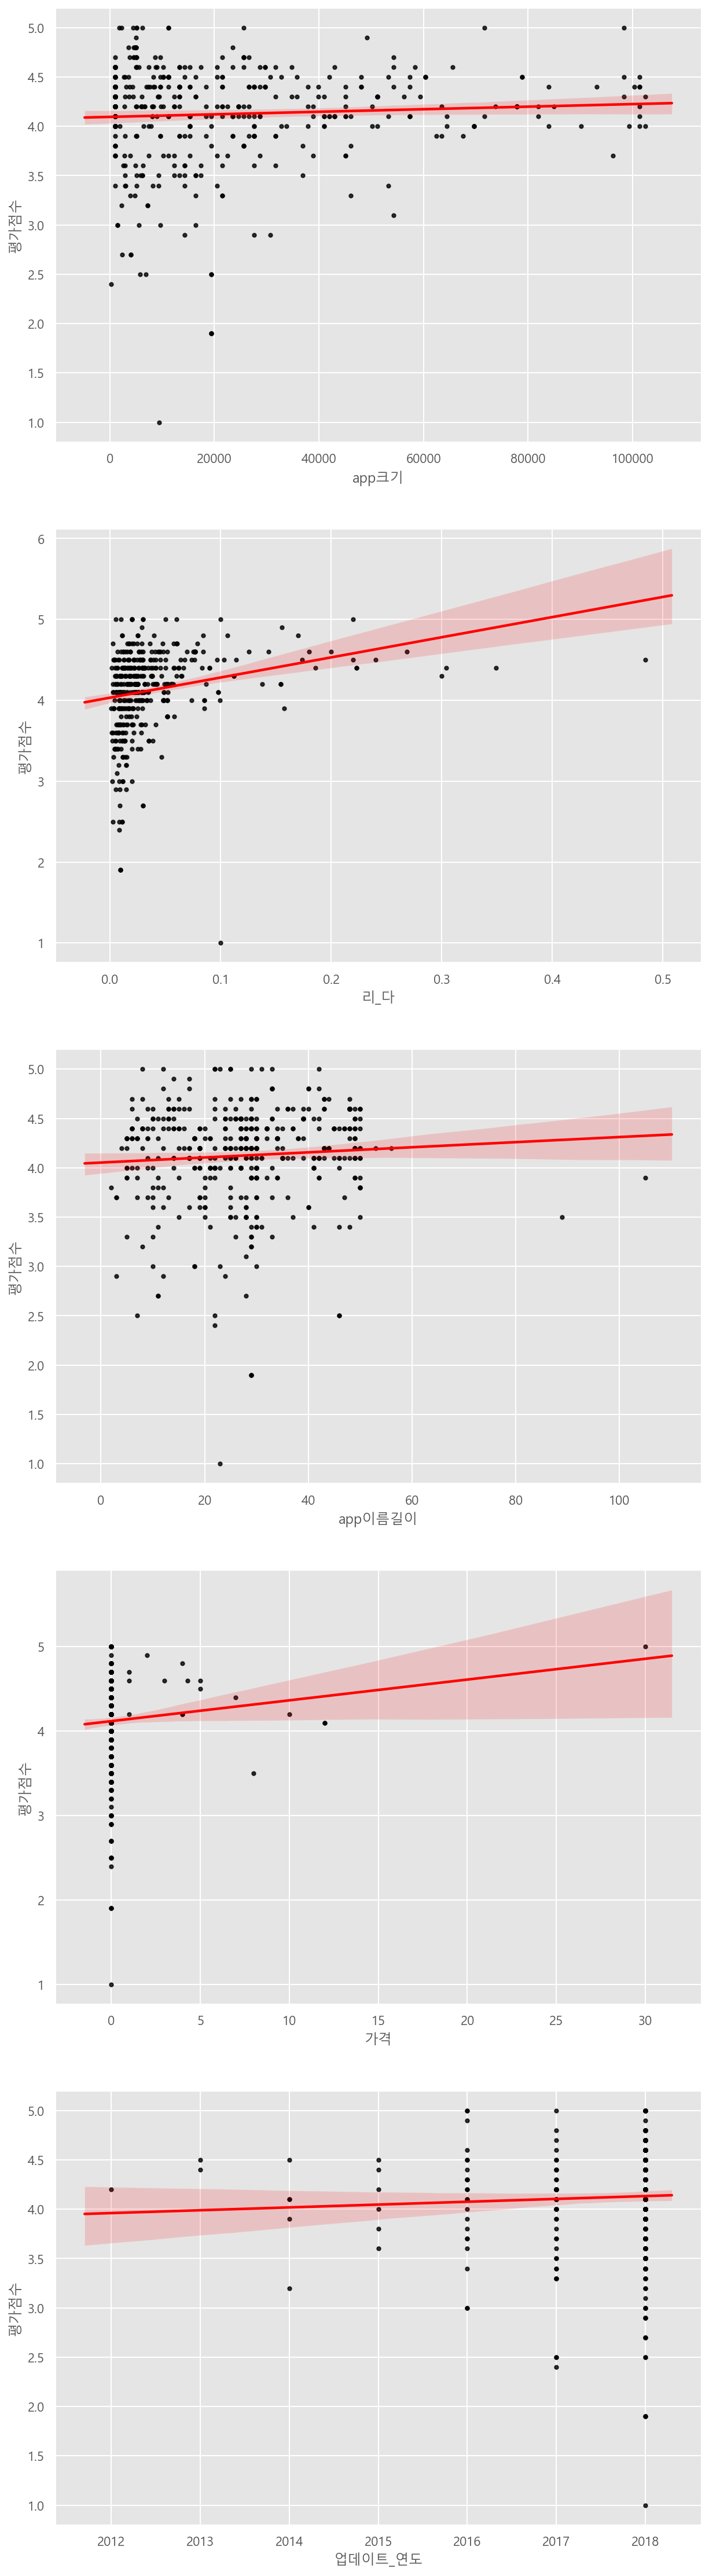

In [64]:
Graph(Mature_17)

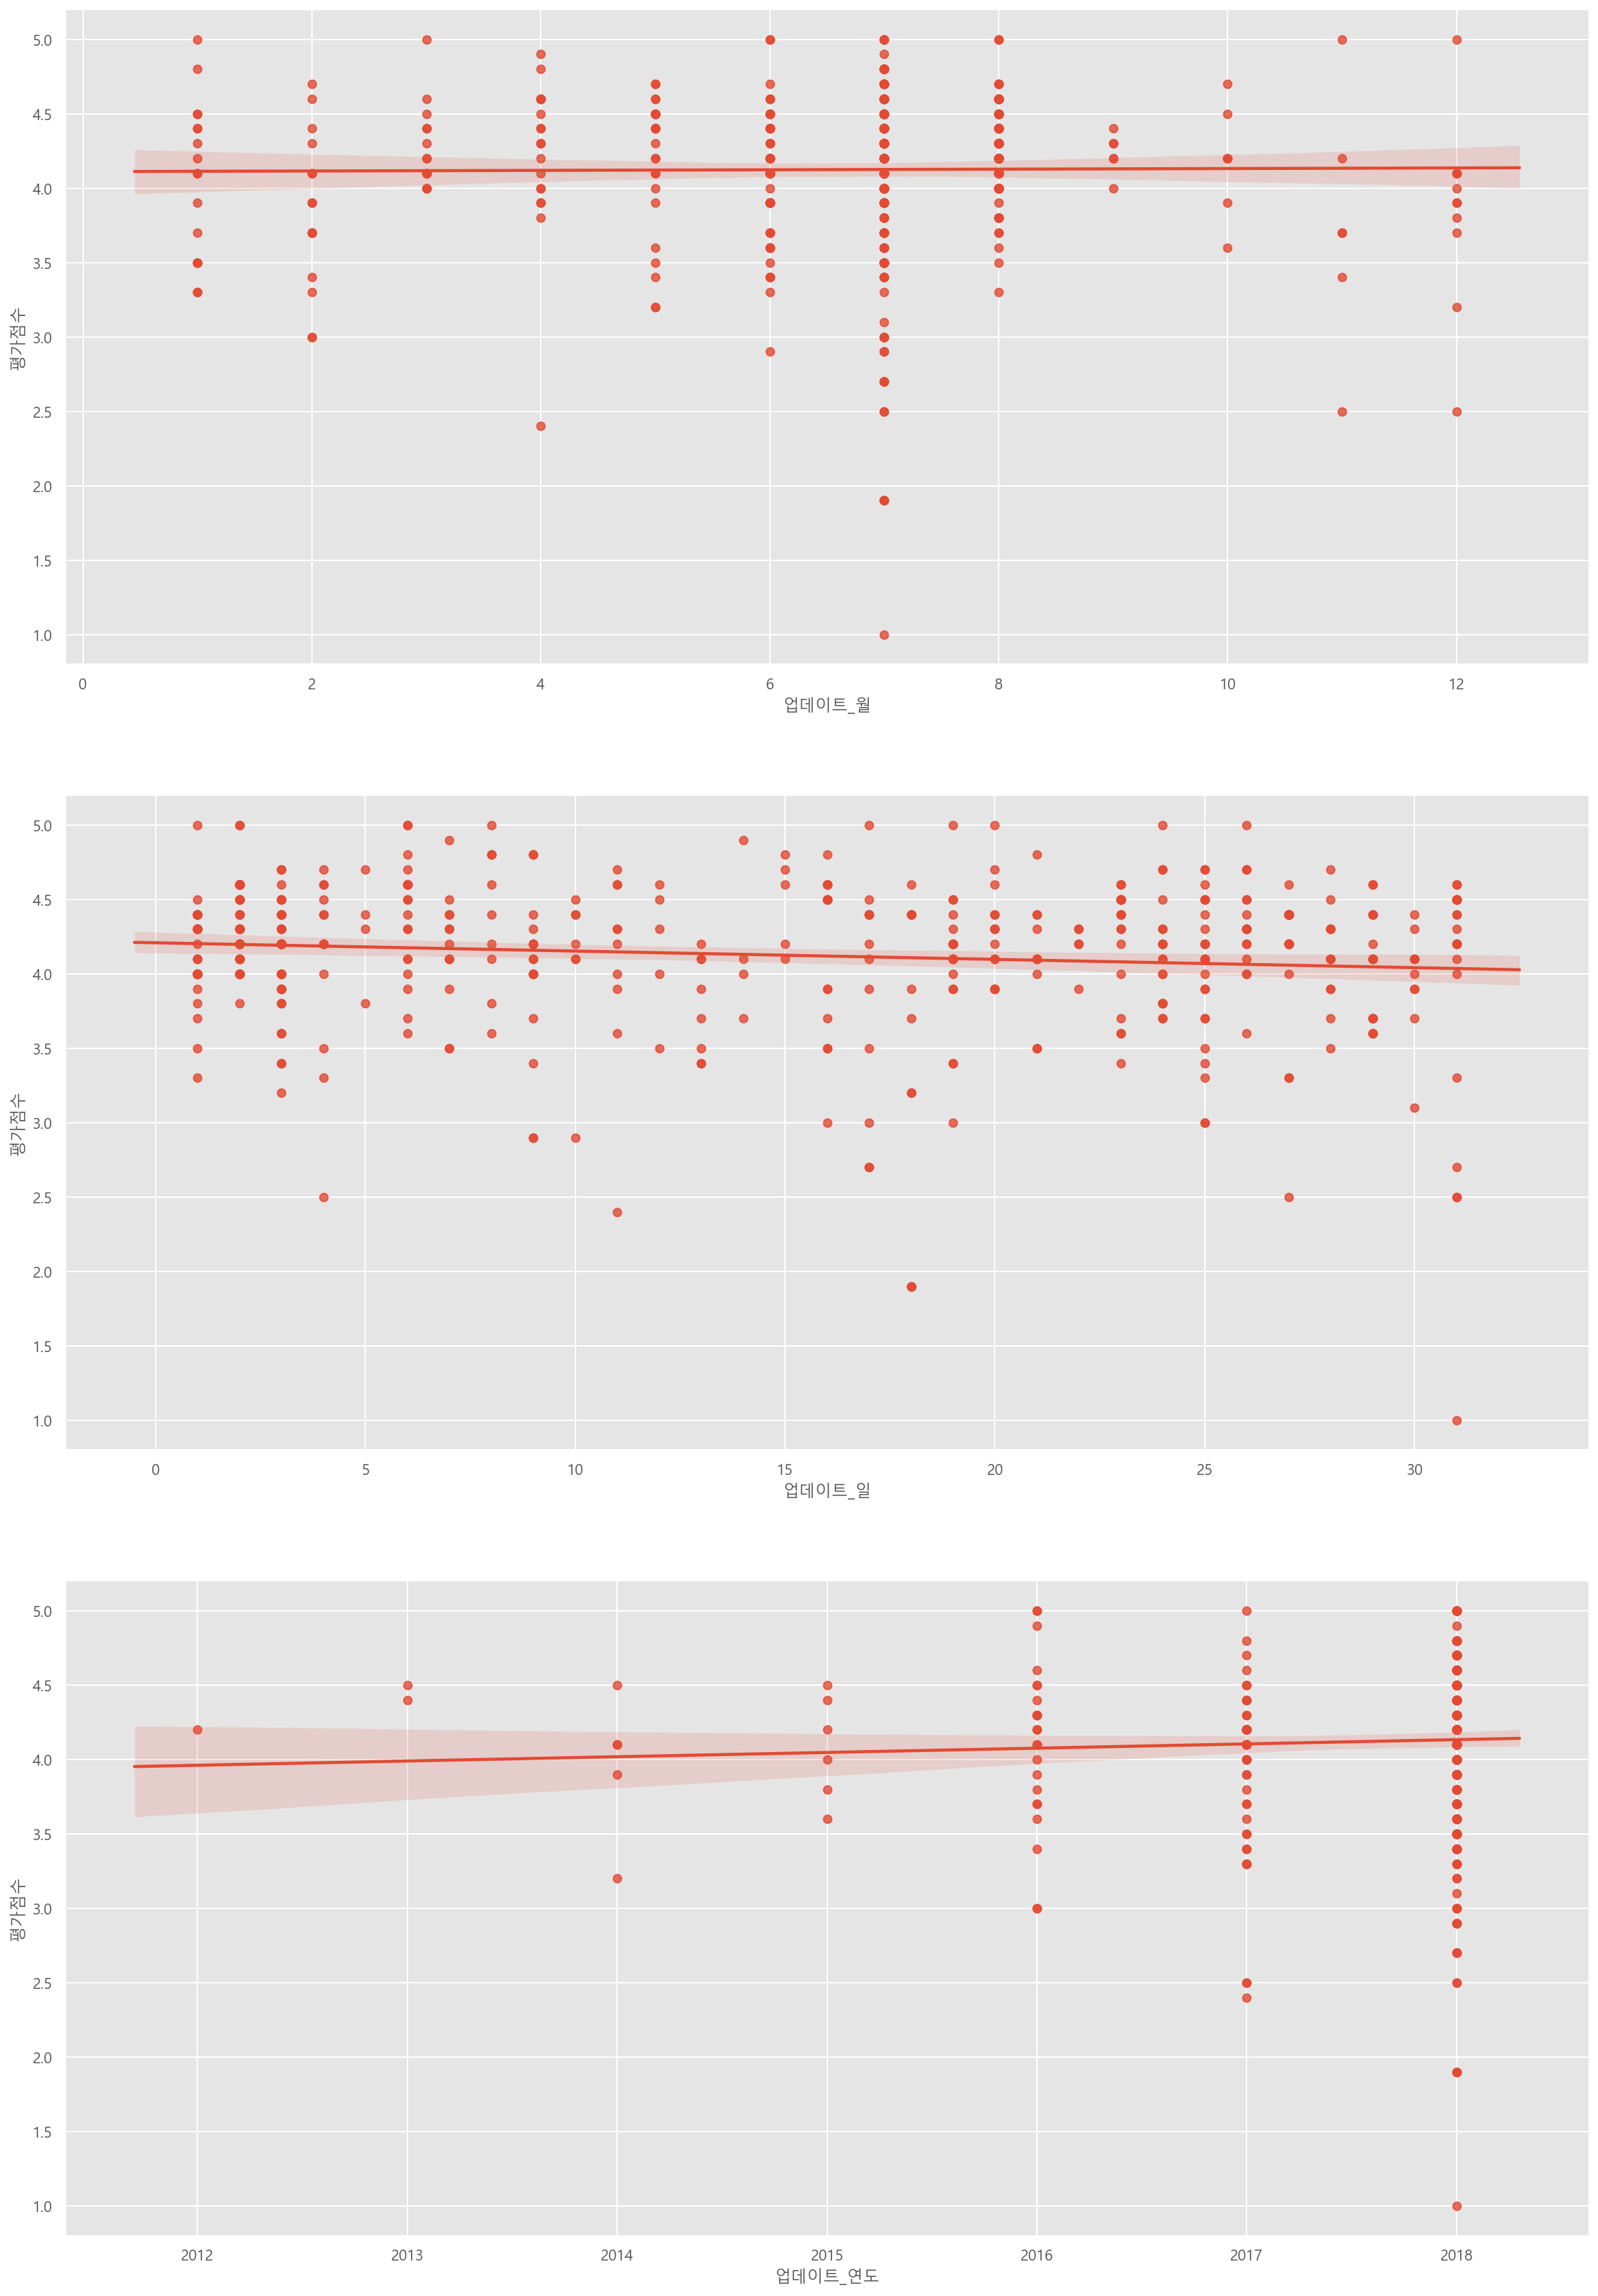

In [65]:
Distplot(Mature_17)

In [66]:
Cramer(Mature_17[['가격','유료구분']])

,가격,유료구분
가격,1.0,1.00
유료구분,1.0,0.94


In [67]:
Mature_17 = Mature_17.drop(['유료구분','업데이트_월','업데이트_일'],axis = 1)

In [68]:
Mature_17.리뷰수 = Mature_17.리뷰수.apply(lambda x : int(x))

AttributeError: 'DataFrame' object has no attribute '리뷰수'

In [ ]:
Mature_17['리_다'] = Mature_17.리뷰수 / Mature_17.다운로드수

In [ ]:
Mature_17 = Mature_17.drop(['다운로드수','리뷰수'],axis = 1)

In [69]:
Mature_17

,app크기,가격,app이름길이,업데이트_연도,리_다
133,8396.8,0.0,30,2017,0.004730
166,23552.0,0.0,17,2018,0.018323
170,5017.6,0.0,7,2014,0.003556
298,5017.6,0.0,40,2018,0.048010
302,15360.0,0.0,32,2018,0.016680
...,...,...,...,...,...
10717,50176.0,0.0,50,2018,0.009183
10765,1024.0,0.0,31,2018,0.006220
10783,73728.0,0.0,44,2017,0.006800
10826,1024.0,0.0,41,2018,0.017697


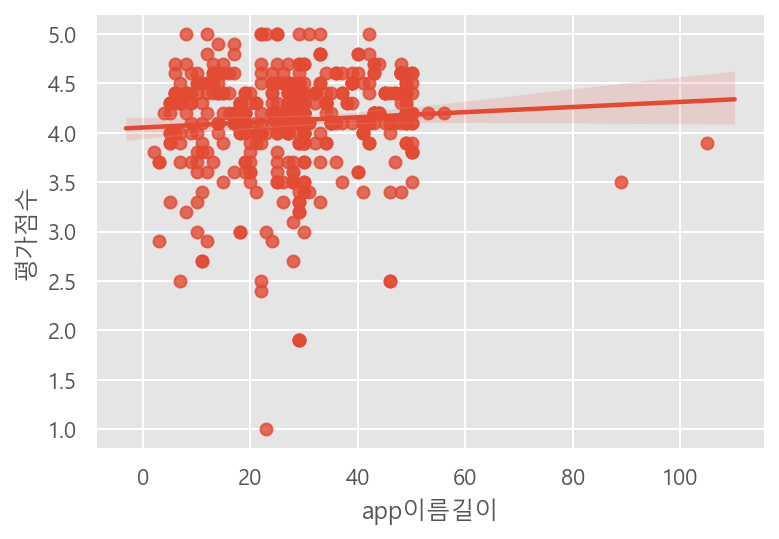

In [24]:
sns.regplot(Mature_17.app이름길이,y)

분석 시작

In [70]:
Mature_17 = sm.add_constant(Mature_17, has_constant = 'add')

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [71]:
Mature_17

,const,app크기,가격,app이름길이,업데이트_연도,리_다
133,1.0,8396.8,0.0,30,2017,0.004730
166,1.0,23552.0,0.0,17,2018,0.018323
170,1.0,5017.6,0.0,7,2014,0.003556
298,1.0,5017.6,0.0,40,2018,0.048010
302,1.0,15360.0,0.0,32,2018,0.016680
...,...,...,...,...,...,...
10717,1.0,50176.0,0.0,50,2018,0.009183
10765,1.0,1024.0,0.0,31,2018,0.006220
10783,1.0,73728.0,0.0,44,2017,0.006800
10826,1.0,1024.0,0.0,41,2018,0.017697


In [72]:
from sklearn.model_selection import KFold

In [73]:
cv = KFold(4)
score_list = []
for i, (idx_train,idx_test) in enumerate(cv.split(Mature_17)):
    train_x = Mature_17.iloc[idx_train]
    train_y = y.reset_index().iloc[idx_train].set_index('index')
    test_x = Mature_17.iloc[idx_test]
    test_y = y.reset_index().iloc[idx_test].set_index('index')
    model = sm.OLS(train_y,train_x)
    fitted_model = model.fit()
    print(fitted_model.summary())
    predict = fitted_model.predict(test_x)
    score_list.append(mean_squared_error(test_y,predict))

                            OLS Regression Results                            
Dep. Variable:                   평가점수   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5.819
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           3.57e-05
Time:                        01:22:26   Log-Likelihood:                -227.61
No. Observations:                 348   AIC:                             467.2
Df Residuals:                     342   BIC:                             490.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -97.3932     59.248     -1.644      0.1

In [27]:
np.array(score_list).mean()

0.2540453094156807

app크기, 가격 app이름 길이 신경 안씀.

In [75]:
Mature_17 = Mature_17.drop(['app크기','가격','app이름길이','업데이트_연도'],axis = 1)

In [76]:
Mature_17

,const,리_다
133,1.0,0.004730
166,1.0,0.018323
170,1.0,0.003556
298,1.0,0.048010
302,1.0,0.016680
...,...,...
10717,1.0,0.009183
10765,1.0,0.006220
10783,1.0,0.006800
10826,1.0,0.017697


In [77]:
cv = KFold(4)
score_list2 = []
for i, (idx_train,idx_test) in enumerate(cv.split(Mature_17)):
    train_x = Mature_17.iloc[idx_train]
    train_y = y.reset_index().iloc[idx_train].set_index('index')
    test_x = Mature_17.iloc[idx_test]
    test_y = y.reset_index().iloc[idx_test].set_index('index')
    model2 = sm.OLS(train_y,train_x)
    fitted_model2 = model2.fit()
    print(fitted_model2.summary())
    predict = fitted_model2.predict(test_x)
    score_list2.append(mean_squared_error(test_y,predict))

                            OLS Regression Results                            
Dep. Variable:                   평가점수   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     17.84
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           3.08e-05
Time:                        01:29:10   Log-Likelihood:                -233.07
No. Observations:                 348   AIC:                             470.1
Df Residuals:                     346   BIC:                             477.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1084      0.032    128.904      0.0

In [114]:
Mature_17.shape

(464, 2)

In [78]:
np.array(score_list2).mean()

0.2532798863658107

실제 적용

In [96]:
with open('Mature_17_Test.pickle','rb') as f:
    Mature_17_Test = pickle.load(f)

In [97]:
Mature_17_Test

,리뷰수,app크기,다운로드수,가격,장르,app이름길이,업데이트_월,업데이트_일,업데이트_연도
129,77,2969.6,10000,0.00,Beauty,35,8,8,2017
134,30,10137.6,10000,0.00,Beauty,29,1,24,2018
610,3,16384.0,1000,0.00,Dating,17,7,15,2018
613,3,4915.2,1000,0.00,Dating,36,7,17,2018
617,2,3788.8,500,0.00,Dating,40,7,16,2018
621,0,3686.4,50,0.00,Dating,18,7,20,2018
623,0,13312.0,50,0.00,Dating,12,7,10,2018
624,1,8908.8,500,0.00,Dating,27,7,23,2018
627,0,39936.0,500,0.00,Dating,18,7,13,2018
629,24,3993.6,1000,0.00,Dating,14,7,26,2018


In [98]:
Mature_17_Test.리뷰수 = Mature_17_Test.리뷰수.apply(lambda x : int(x))

In [99]:
Mature_17_Test['리_다'] = Mature_17_Test.리뷰수 / Mature_17_Test.다운로드수

In [100]:
Mature_17_Test.head()

,리뷰수,app크기,다운로드수,가격,장르,app이름길이,업데이트_월,업데이트_일,업데이트_연도,리_다
129,77,2969.6,10000,0.0,Beauty,35,8,8,2017,0.0077
134,30,10137.6,10000,0.0,Beauty,29,1,24,2018,0.0030
610,3,16384.0,1000,0.0,Dating,17,7,15,2018,0.0030
613,3,4915.2,1000,0.0,Dating,36,7,17,2018,0.0030
617,2,3788.8,500,0.0,Dating,40,7,16,2018,0.0040


In [101]:
Mature_17_Test = Mature_17_Test.drop(['리뷰수','app크기','다운로드수','가격','app이름길이','업데이트_월','업데이트_일'],axis = 1)

In [102]:
Mature_17_Test = Mature_17_Test.drop(['장르'],axis = 1)

In [106]:
Mature_17_Test = Mature_17_Test.drop(['업데이트_연도'],axis= 1)

In [107]:
Mature_17_Test = sm.add_constant(Mature_17_Test,has_constant='add')

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [110]:
Mature_17_Test

,const,리_다
129,1.0,0.00770
134,1.0,0.00300
610,1.0,0.00300
613,1.0,0.00300
617,1.0,0.00400
621,1.0,0.00000
623,1.0,0.00000
624,1.0,0.00200
627,1.0,0.00000
629,1.0,0.02400


In [111]:
Result_predict = fitted_model2.predict(Mature_17_Test)

In [115]:
Result_predict.describe()

count    38.000000
mean      4.120236
std       0.189319
min       4.050371
25%       4.050371
50%       4.055157
75%       4.067780
max       5.007555
dtype: float64

In [116]:
Result_predict[Result_predict > 5]

7504    5.007555
dtype: float64

In [113]:
with open('Mature_result.pickle','wb') as f:
    pickle.dump(Result_predict,f)